# LangSmith RAG Evaluation 기초예제
## 작성자 : AISchool ( http://aischool.ai/%ec%98%a8%eb%9d%bc%ec%9d%b8-%ea%b0%95%ec%9d%98-%ec%b9%b4%ed%85%8c%ea%b3%a0%eb%a6%ac/ )
## Reference : https://docs.smith.langchain.com/tutorials/Developers/rag

# Overview

아래에서 워크플로의 각 단계를 논의할 것입니다.

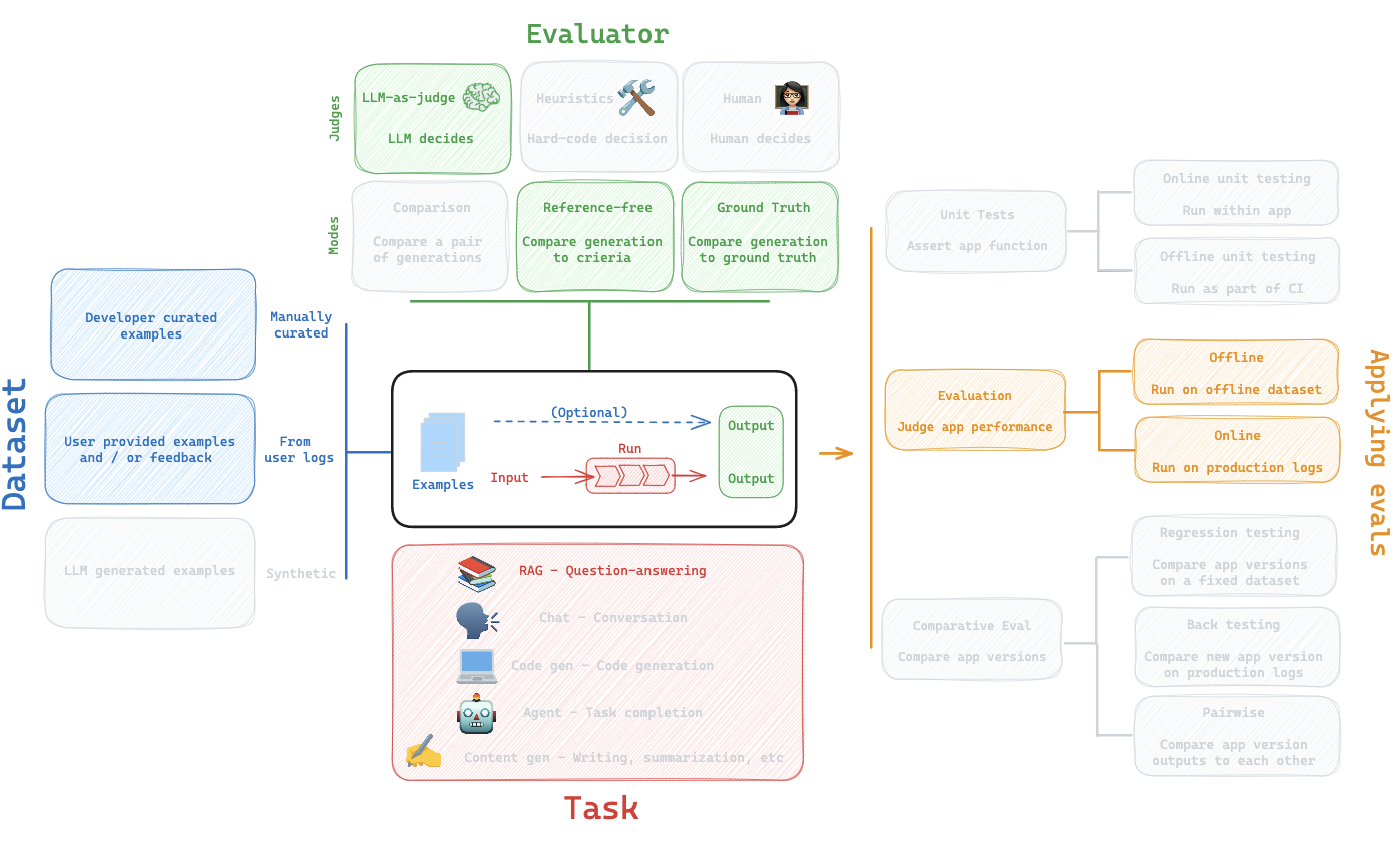

# 라이브러리 설치

In [ ]:
!pip install -U langsmith langchain_openai langchain-community chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.9 MB/s eta 0:00

# Dataset

다음은 우리가 사용할 LCEL(LangChain Expression Language) 관련 질문들의 데이터셋입니다.

이 데이터셋은 LangSmith UI에서 CSV 업로드를 통해 생성되었습니다:

https://smith.langchain.com/public/730d833b-74da-43e2-a614-4e2ca2502606/d

# API Key 설정

In [ ]:
import os
from uuid import uuid4

unique_id = uuid4().hex[0:8]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"RAG Evaluations - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "여러분의_LANGCHAIN_API_KEY"

In [ ]:
unique_id

'a9b5f3b5'

In [ ]:
os.environ["OPENAI_API_KEY"] = "여러분의_OPENAI_API_KEY"

In [ ]:
### Dataset name
dataset_name = "LCEL-QA"

In [ ]:
from langsmith import Client

# Initialize the LangSmith Client so we can use to get the dataset
ls_client = Client()

In [ ]:
public_datasets = [
    "https://smith.langchain.com/public/730d833b-74da-43e2-a614-4e2ca2502606/d",  # LCEL-QA
]

for ds in public_datasets:
    ls_client.clone_public_dataset(ds)

# Task

다음은 LCEL(LangChain Expression Language) ( https://python.langchain.com/v0.1/docs/expression_language/ ) 문서에 대해 RAG를 수행할 체인입니다.

우리는 retriever를 생성하고 관련 문서를 검색하는 데에만 LangChain을 사용할 것입니다.

전체 파이프라인은 LangChain을 사용하지 않으며, 파이프라인이 LangChain으로 구축되었는지 여부와 상관없이 LangSmith는 작동합니다.

여기에서는 검색된 문서(retrieved documents)를 최종 답변의 일부로 반환합니다.

In [ ]:
### INDEX

from bs4 import BeautifulSoup as Soup
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load docs
url = "https://python.langchain.com/v0.1/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Split into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=4500, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Embed and store in Chroma
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Index
retriever = vectorstore.as_retriever()

In [ ]:
### RAG bot

import openai
from langsmith import traceable
from langsmith.wrappers import wrap_openai

class RagBot:

    def __init__(self, retriever, model: str = "gpt-4o-mini"):
        self._retriever = retriever
        # Wrapping the client instruments the LLM
        self._client = wrap_openai(openai.Client())
        self._model = model

    @traceable()
    def retrieve_docs(self, question):
        return self._retriever.invoke(question)

    @traceable()
    def invoke_llm(self, question, docs):
        response = self._client.chat.completions.create(
            model=self._model,
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful AI code assistant with expertise in LCEL."
                    " Use the following docs to produce a concise code solution to the user question.\n\n"
                    f"## Docs\n\n{docs}",
                },
                {"role": "user", "content": question},
            ],
        )

        # Evaluators will expect "answer" and "contexts"
        return {
            "answer": response.choices[0].message.content,
            "contexts": [str(doc) for doc in docs],
        }

    @traceable()
    def get_answer(self, question: str):
        docs = self.retrieve_docs(question)
        return self.invoke_llm(question, docs)

rag_bot = RagBot(retriever)

In [ ]:
response = rag_bot.get_answer("How to build a RAG chain in LCEL?")
response["answer"][:150]

'To build a Retrieval-Augmented Generation (RAG) chain in LangChain Expression Language (LCEL), you can follow these steps:\n\n1. **Set up your environme'

In [ ]:
response["answer"]

'To build a Retrieval-Augmented Generation (RAG) chain in LangChain Expression Language (LCEL), you can follow these steps:\n\n1. **Set up your environment**: Install the necessary LangChain libraries.\n   ```bash\n   pip install langchain langchain-openai langchain-core\n   ```\n\n2. **Import the required modules**: This includes the retriever and language model components.\n\n3. **Define your components**:\n   - Create a retriever to fetch relevant documents.\n   - Use a language model for generating responses based on the retrieved documents.\n   - Optionally, include a prompt template and output parser to format the input and output.\n\n4. **Build the RAG chain**: Use the pipe operator to chain the components together.\n\nHere\'s a concise code example demonstrating how to build a RAG chain in LCEL:\n\n```python\nfrom langchain_openai import ChatOpenAI\nfrom langchain_core.prompts import ChatPromptTemplate\nfrom langchain_core.output_parsers import StrOutputParser\nfrom langchain_c

다음 기능을 정의하세요:

1.   데이터셋 example을 입력으로 받음
2.   example에서 관련된 키(예: question)를 추출함
3.   이를 RAG 체인에 전달함
4.   RAG 체인에서 관련된 출력 값을 반환함

In [ ]:
def predict_rag_answer(example: dict):
    """Use this for answer evaluation"""
    response = rag_bot.get_answer(example["input_question"])
    return {"answer": response["answer"]}

def predict_rag_answer_with_context(example: dict):
    """Use this for evaluation of retrieved documents and hallucinations"""
    response = rag_bot.get_answer(example["input_question"])
    return {"answer": response["answer"], "contexts": response["contexts"]}

# Evaluator

사용자들이 일반적으로 관심을 가지는 RAG 평가 유형은 최소 4가지가 있습니다.

**1. Response vs reference answer**

*   **Goal**: **"RAG 체인의 답변이 기준 답변(정답)(ground-truth answer)과 비교하여 얼마나 유사하거나 정확한가"**를 측정함
*   **Mode**: 데이터셋을 통해 제공된 기준 답변(참조 답변)(ground truth (reference) answer)을 사용함
*   **Judge**: LLM을 평가자(LLM-as-judge)로 사용하여 답변의 정확성(correctness)을 평가함

**2. Response vs input**

*   **Goal**: **"생성된 응답이 초기 사용자 입력을 얼마나 잘 반영하는가"**를 측정함
*   **Mode**: 참조 없이 진행되며(Reference-free), 답변(answer)을 입력된 질문(input question)과 비교함
*   **Judge**: LLM을 평가자로 사용하여 답변의 관련성(relevance), 유용성 등(helpfulness)을 평가함

**3. Response vs retrieved docs**

*   **Goal**: **"생성된 응답이 검색된 문맥과 얼마나 일치하는가"**를 측정함
*   **Mode**: 참조 없이 진행되며(Reference-free), 답변(answer)을 검색된 문맥(retrieved context)과 비교함
*   **Judge**: LLM을 평가자로 사용하여 신뢰성(faithfulness), 환각 여부(hallucinations) 등을 평가함

**4. Retrieved docs vs input**

*   **Goal**: **"이 쿼리에 대해 검색된 결과가 얼마나 좋은가"**를 측정함
*   **Mode**: 참조 없이 진행되며(Reference-free), 질문(question)을 검색된 문맥(retrieved context)과 비교함
*   **Judge**: LLM을 평가자로 사용하여 관련성(relevance)을 평가함























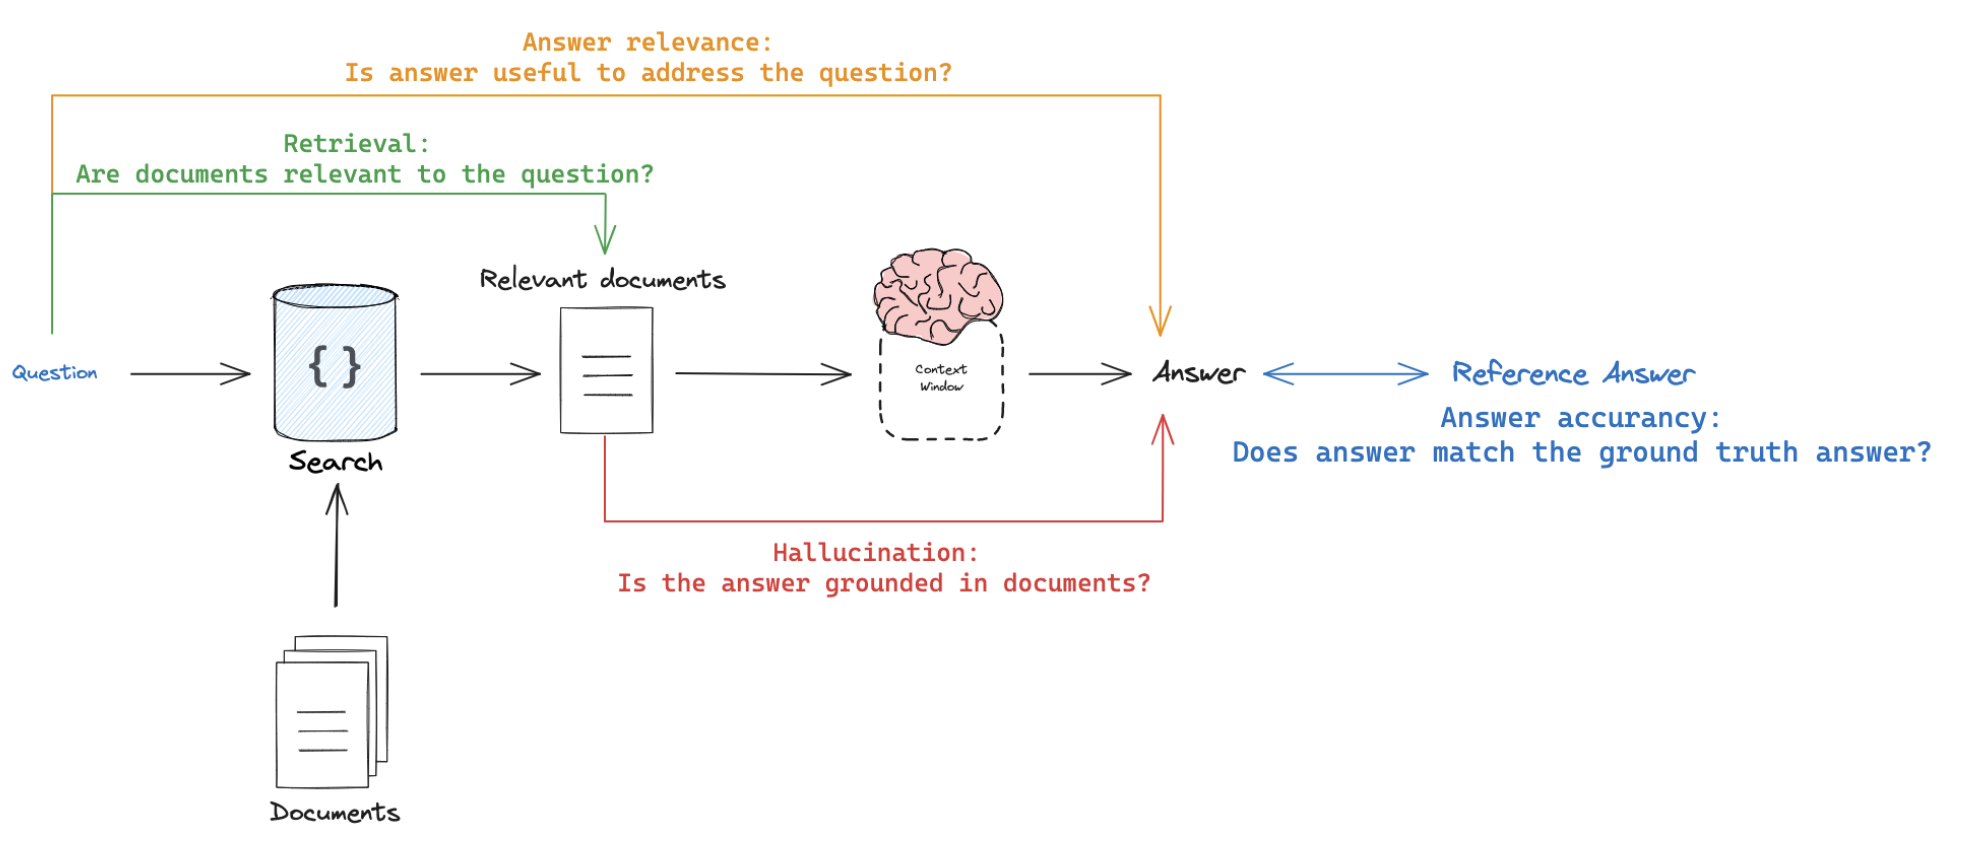

# Response vs reference answer

다음은 우리가 사용할 수 있는 예제 프롬프트입니다:

https://smith.langchain.com/hub/langchain-ai/rag-answer-vs-reference

참고용으로 LangSmith 평가 시리즈의 비디오도 첨부합니다:

https://youtu.be/lTfhw_9cJqc?feature=shared

다음은 우리의 평가자 함수입니다:


*   run은 predict_rag_answer의 호출로, answer라는 key를 가지고 있습니다.
*   example은 우리의 평가 세트에서 가져온 것으로, **input_quenstion**과 **output_answer**라는 키를 가지고 있습니다.
*   우리는 이 값들을 추출하여 평가자(grader)에게 전달합니다.




In [ ]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = prompt = hub.pull("langchain-ai/rag-answer-vs-reference")

def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get question, ground truth answer, RAG chain answer
    input_question = example.inputs["input_question"]
    reference = example.outputs["output_answer"]
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke({"question": input_question,
                                  "correct_answer": reference,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_v_reference_score", "score": score}

In [ ]:
grade_prompt_answer_accuracy

StructuredPrompt(input_variables=['correct_answer', 'question', 'student_answer'], metadata={'lc_hub_owner': 'langchain-ai', 'lc_hub_repo': 'rag-answer-vs-reference', 'lc_hub_commit_hash': '91188455a4d936aa5b62ab17ccf56076b60df8b3e700629c91d741287390f144'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="You are a teacher grading a quiz. \n\nYou will be given a QUESTION, the GROUND TRUTH (correct) ANSWER, and the STUDENT ANSWER. \n\nHere is the grade criteria to follow:\n(1) Grade the student answers based ONLY on their factual accuracy relative to the ground truth answer. \n(2) Ensure that the student answer does not contain any conflicting statements.\n(3) It is OK if the student answer contains more information than the ground truth answer, as long as it is factually accurate relative to the  ground truth answer.\n\nScore:\nA score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score. \nA score of 

In [ ]:
# SYSTEM:
# You are a teacher grading a quiz.

# You will be given a QUESTION, the GROUND TRUTH (correct) ANSWER, and the STUDENT ANSWER.

# Here is the grade criteria to follow:
# (1) Grade the student answers based ONLY on their factual accuracy relative to the ground truth answer.
# (2) Ensure that the student answer does not contain any conflicting statements.
# (3) It is OK if the student answer contains more information than the ground truth answer, as long as it is factually accurate relative to the  ground truth answer.

# Score:
# A score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score.
# A score of 0 means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

# Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.

# Avoid simply stating the correct answer at the outset.

# HUMAN:
# QUESTION: {{question}}
# GROUND TRUTH ANSWER: {{correct_answer}}
# STUDENT ANSWER: {{student_answer}}

In [ ]:
# SYSTEM:
# 당신은 퀴즈를 채점하는 교사입니다.

# 질문, 정답(기준 답변), 그리고 학생의 답변이 주어질 것입니다.

# 다음 채점 기준을 따르세요:
# (1) 학생의 답변을 기준 답변과 비교하여 사실적으로 정확한지 여부에만 근거해 채점하세요.
# (2) 학생의 답변에 상충되는 진술이 없는지 확인하세요.
# (3) 학생의 답변이 기준 답변보다 더 많은 정보를 포함하고 있어도 괜찮지만, 해당 정보가 기준 답변과 비교해 사실적으로 정확해야 합니다.

# 점수:
# 점수 1은 학생의 답변이 모든 기준을 충족했음을 의미합니다. 이 점수는 최고(가장 좋은) 점수입니다.
# 점수 0은 학생의 답변이 모든 기준을 충족하지 못했음을 의미합니다. 이 점수는 줄 수 있는 최저 점수입니다.

# 당신의 논리와 결론이 올바른지 확인하기 위해 단계별로 이유를 설명하세요.

# 단순히 정답을 먼저 제시하는 것은 피하세요.

# HUMAN:
# QUESTION: {{question}}
# GROUND TRUTH ANSWER: {{correct_answer}}
# STUDENT ANSWER: {{student_answer}}

이제 평가를 시작합니다:

*   **predict_rag_answer**: 평가 세트에서 example을 가져와 질문을 추출하고, 이를 RAG 체인에 전달합니다.
*   **answer_evaluator**: RAG 체인의 답변, 질문, 그리고 기준 답변을 평가자에게 전달합니다.


In [ ]:
from langsmith.evaluation import evaluate

experiment_results = evaluate(
    predict_rag_answer,
    data=dataset_name,
    evaluators=[answer_evaluator],
    experiment_prefix="rag-answer-v-reference",
    metadata={"version": "LCEL context, gpt-4o"},
)

# Response vs input

다음은 우리가 사용할 수 있는 예제 프롬프트입니다:

https://smith.langchain.com/hub/langchain-ai/rag-answer-helpfulness

정보 흐름은 위와 유사하지만, 단순히 실행된 답변(answer)과 예제 질문(question)을 비교합니다.

In [ ]:
# Grade prompt
grade_prompt_answer_helpfulness = prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def answer_helpfulness_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer helpfulness
    """

    # Get question, ground truth answer, RAG chain answer
    input_question = example.inputs["input_question"]
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_answer_helpfulness | llm

    # Run evaluator
    score = answer_grader.invoke({"question": input_question,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_helpfulness_score", "score": score}

In [ ]:
grade_prompt_answer_helpfulness

StructuredPrompt(input_variables=['question', 'student_answer'], metadata={'lc_hub_owner': 'langchain-ai', 'lc_hub_repo': 'rag-answer-helpfulness', 'lc_hub_commit_hash': 'a08c5b1138556af9d24cec85f73977227f79c252ab71134b9ce4e72076ca8db5'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="You are a teacher grading a quiz. \n\nYou will be given a QUESTION and a STUDENT ANSWER. \n\nHere is the grade criteria to follow:\n(1) Ensure the STUDENT ANSWER is concise and relevant to the QUESTION\n(2) Ensure the STUDENT ANSWER helps to answer the QUESTION\n\nScore:\nA score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score. \nA score of 0 means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.\n\nExplain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. \n\nAvoid simply stating the correct answer at the outset.

In [ ]:
# SYSTEM:
# You are a teacher grading a quiz.

# You will be given a QUESTION and a STUDENT ANSWER.

# Here is the grade criteria to follow:

# (1) Ensure the STUDENT ANSWER is concise and relevant to the QUESTION
# (2) Ensure the STUDENT ANSWER helps to answer the QUESTION

# Score:
# A score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score.
# A score of 0 means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

# Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.

# Avoid simply stating the correct answer at the outset.

# HUMAN:
# STUDENT ANSWER: {{student_answer}}
# QUESTION: {{question}}

In [ ]:
# SYSTEM:
# 당신은 퀴즈를 채점하는 교사입니다.

# 질문과 학생의 답변이 주어질 것입니다.

# 다음 채점 기준을 따르세요:
# (1) 학생의 답변이 질문에 대해 간결하고 적절한지 확인하세요.
# (2) 학생의 답변이 질문에 대한 답변으로서 도움이 되는지 확인하세요.

# 점수:
# 점수 1은 학생의 답변이 모든 기준을 충족했음을 의미합니다. 이 점수는 최고(가장 좋은) 점수입니다.
# 점수 0은 학생의 답변이 모든 기준을 충족하지 못했음을 의미합니다. 이 점수는 줄 수 있는 최저 점수입니다.

# 당신의 논리와 결론이 올바른지 확인하기 위해 단계별로 이유를 설명하세요.

# 단순히 정답을 먼저 제시하는 것은 피하세요.

# HUMAN:
# STUDENT ANSWER: {{student_answer}}
# QUESTION: {{question}}

In [ ]:
experiment_results = evaluate(
    predict_rag_answer,
    data=dataset_name,
    evaluators=[answer_helpfulness_evaluator],
    experiment_prefix="rag-answer-helpfulness",
    metadata={"version": "LCEL context, gpt-4o"},
)

# Response vs retrieved docs

다음은 우리가 사용할 수 있는 예제 프롬프트입니다:

https://smith.langchain.com/hub/langchain-ai/rag-answer-hallucination

참고용으로 LangSmith 평가 시리즈의 비디오도 첨부합니다:

https://youtu.be/IlNglM9bKLw?feature=shared

In [ ]:
# Prompt
grade_prompt_hallucinations = prompt = hub.pull("langchain-ai/rag-answer-hallucination")

def answer_hallucination_evaluator(run, example) -> dict:
    """
    A simple evaluator for generation hallucination
    """

    # RAG inputs
    input_question = example.inputs["input_question"]
    contexts = run.outputs["contexts"]

    # RAG answer
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_hallucinations | llm

    # Get score
    score = answer_grader.invoke({"documents": contexts,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_hallucination", "score": score}

In [ ]:
grade_prompt_hallucinations

StructuredPrompt(input_variables=['documents', 'student_answer'], metadata={'lc_hub_owner': 'langchain-ai', 'lc_hub_repo': 'rag-answer-hallucination', 'lc_hub_commit_hash': 'db6402bc1ab143940cba1ccfaeaeca1d19b89933507f16476548cdb27b19dc0a'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a teacher grading a quiz. \n\nYou will be given FACTS  and a STUDENT ANSWER. \n\nHere is the grade criteria to follow:\n(1) Ensure the STUDENT ANSWER is grounded in the FACTS. \n(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.\n\nScore:\nA score of 1 means that the student\'s answer meets all of the criteria. This is the highest (best) score. \nA score of 0 means that the student\'s answer does not meet all of the criteria. This is the lowest possible score you can give.\n\nExplain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. \n\nAvoid simply statin

In [ ]:
# SYSTEM:
# You are a teacher grading a quiz.

# You will be given FACTS  and a STUDENT ANSWER.

# Here is the grade criteria to follow:
# (1) Ensure the STUDENT ANSWER is grounded in the FACTS.
# (2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

# Score:
# A score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score.
# A score of 0 means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

# Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.

# Avoid simply stating the correct answer at the outset.

# HUMAN:
# FACTS: {{documents}}
# STUDENT ANSWER: {{student_answer}}

In [ ]:
# SYSTEM:
# 당신은 퀴즈를 채점하는 교사입니다.

# 사실(Facts)과 학생의 답변이 주어질 것입니다.

# 다음 채점 기준을 따르세요:
# (1) 학생의 답변이 사실에 근거하고 있는지 확인하세요.
# (2) 학생의 답변에 사실의 범위를 벗어난 "환각된" 정보가 포함되지 않았는지 확인하세요.

# 점수:
# 점수 1은 학생의 답변이 모든 기준을 충족했음을 의미합니다. 이 점수는 최고(가장 좋은) 점수입니다.
# 점수 0은 학생의 답변이 모든 기준을 충족하지 못했음을 의미합니다. 이 점수는 줄 수 있는 최저 점수입니다.

# 당신의 논리와 결론이 올바른지 확인하기 위해 단계별로 이유를 설명하세요.

# 단순히 정답을 먼저 제시하는 것은 피하세요.

# HUMAN:
# FACTS: {{documents}}
# STUDENT ANSWER: {{student_answer}}

In [ ]:
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[answer_hallucination_evaluator],
    experiment_prefix="rag-answer-hallucination",
    metadata={"version": "LCEL context, gpt-4o"},
)

# Retrieved docs vs input

다음은 우리가 사용할 수 있는 예제 프롬프트입니다:

https://smith.langchain.com/hub/langchain-ai/rag-document-relevance

참고용으로 LangSmith 평가 시리즈의 비디오도 첨부합니다:

https://youtu.be/Fr_7HtHjcf0?feature=shared








In [ ]:
# Grade prompt
grade_prompt_doc_relevance = hub.pull("langchain-ai/rag-document-relevance")

def docs_relevance_evaluator(run, example) -> dict:
    """
    A simple evaluator for document relevance
    """

    # RAG inputs
    input_question = example.inputs["input_question"]
    contexts = run.outputs["contexts"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_doc_relevance | llm

    # Get score
    score = answer_grader.invoke({"question":input_question,
                                  "documents":contexts})
    score = score["Score"]

    return {"key": "document_relevance", "score": score}

In [ ]:
grade_prompt_doc_relevance

StructuredPrompt(input_variables=['documents', 'question'], metadata={'lc_hub_owner': 'langchain-ai', 'lc_hub_repo': 'rag-document-relevance', 'lc_hub_commit_hash': '4004d2b75d5faa1a405ee59bb2bbf6e085bc6d731348d30cb8530854b00fd5fe'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a teacher grading a quiz. \n\nYou will be given a QUESTION and a set of FACTS provided by the student. \n\nHere is the grade criteria to follow:\n(1) You goal is to identify FACTS that are completely unrelated to the QUESTION\n(2) If the facts contain ANY keywords or semantic meaning related to the question, consider them relevant\n(3) It is OK if the facts have SOME information that is unrelated to the question (2) is met \n\nScore:\nA score of 1 means that the FACT contain ANY keywords or semantic meaning related to the QUESTION and are therefore relevant. This is the highest (best) score. \nA score of 0 means that the FACTS are completely unrelated to the Q

In [ ]:
# SYSTEM:
# You are a teacher grading a quiz.

# You will be given a QUESTION and a set of FACTS provided by the student.

# Here is the grade criteria to follow:
# (1) You goal is to identify FACTS that are completely unrelated to the QUESTION
# (2) If the facts contain ANY keywords or semantic meaning related to the question, consider them relevant
# (3) It is OK if the facts have SOME information that is unrelated to the question (2) is met

# Score:
# A score of 1 means that the FACT contain ANY keywords or semantic meaning related to the QUESTION and are therefore relevant. This is the highest (best) score.
# A score of 0 means that the FACTS are completely unrelated to the QUESTION. This is the lowest possible score you can give.

# Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.

# Avoid simply stating the correct answer at the outset.

# HUMAN:
# FACTS: {{documents}}
# QUESTION: {{question}}

In [ ]:
# SYSTEM:
# 당신은 퀴즈를 채점하는 교사입니다.

# 질문과 학생이 제공한 사실(Facts) 세트가 주어질 것입니다.

# 다음 채점 기준을 따르세요:
# (1) 목표는 질문과 완전히 관련이 없는 사실을 식별하는 것입니다.
# (2) 사실이 질문과 관련된 키워드나 의미를 포함하고 있다면, 그 사실을 관련성이 있다고 간주하세요.
# (3) 사실이 질문과 관련 없는 일부 정보를 포함하고 있어도 괜찮습니다. (2) 조건이 충족되면 됩니다.

# 점수:
# 점수 1은 사실이 질문과 관련된 키워드나 의미를 포함하고 있어 관련성이 있음을 의미합니다. 이 점수는 최고(가장 좋은) 점수입니다.
# 점수 0은 사실이 질문과 완전히 관련이 없음을 의미합니다. 이 점수는 줄 수 있는 최저 점수입니다.

# 당신의 논리와 결론이 올바른지 확인하기 위해 단계별로 이유를 설명하세요.

# 단순히 정답을 먼저 제시하는 것은 피하세요.

# HUMAN:
# FACTS: {{documents}}
# QUESTION: {{question}}

In [ ]:
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[docs_relevance_evaluator],
    experiment_prefix="rag-doc-relevance",
    metadata={"version": "LCEL context, gpt-4o"},
)